In [94]:
import h5py
import numpy as np
from datetime import datetime, timezone, timedelta
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import PowerNorm
import gc

from collections import deque, defaultdict, Counter

import json
from pathlib import Path

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import PowerNorm

import re

In [59]:
dataset_path = "/Volumes/SSD/mark/Documents/Works/MT_Dataset/mt_tracks_20250714.h5"

if "ds" in vars():
    ds.close()   # type: ignore

ds = h5py.File(dataset_path, "r")
for attr in ds.attrs:
    print(f"{attr}: {ds.attrs[attr]}")

author: Mark Vodyanitskiy (mvodya@icloud.com)
created_at: 2025-07-13T14:26:08.378871
filter_rules: MIN_TOTAL_POINTS=50, MIN_MOVING_POINTS=5, MIN_MAX_SPEED=20, SPEED_MOVING_MIN=10, SPEED_SANITY_MAX=800
filtered_at: 2026-01-08T06:02:47.931391
sources_count: 27555
sources_size: 439.3Gb
tracks_built_at: 2026-01-09T17:19:14.225437
tracks_count: 11731643
tracks_rules: SPEED_MOVING_MIN=10, STOP_RADIUS_M=250.0, STOP_DWELL_SEC=1800, GAP_HARD_SEC=18000, GAP_VERY_HARD_SEC=36000, DIST_AFTER_GAP_M=150000.0, JUMP_HARD_M=250000.0, DEST_GAP_SEC=14400, DEST_DIST_M=50000.0
version: 1.0


In [67]:
extent = (105.0, 171.0, 17.0, 60.0)  # (min_lon, max_lon, min_lat, max_lat)

# Grid resolution
bins = (1600, 1200)   # (nx, ny)

# Порог отбора ячеек
# Варианты:
#  - percentile: например 99.5 перцентиль от ненулевых
#  - absolute: например >= 50 событий (start+end) в ячейке
threshold_mode = "percentile"
threshold_value = 99.5

# Минимальный размер кластера (в ячейках)
min_cluster_cells = 3

# HDF5 chunk rows
chunk_rows_tracks = 2_000_000
chunk_rows_positions = 2_000_000

gap_thr_sec = 40 * 60  # порог разрыва плохих дырок

In [68]:
def build_start_end_heatmaps_tracks(ds_tracks, extent, bins=(800, 600), chunk_rows=2_000_000, min_points=None):
    min_lon, max_lon, min_lat, max_lat = map(float, extent)
    nx, ny = map(int, bins)

    x_edges = np.linspace(min_lon, max_lon, nx + 1, dtype=np.float64)
    y_edges = np.linspace(min_lat, max_lat, ny + 1, dtype=np.float64)

    heat_start = np.zeros((ny, nx), dtype=np.uint32)
    heat_end   = np.zeros((ny, nx), dtype=np.uint32)

    n = ds_tracks.shape[0]
    for s in tqdm(range(0, n, chunk_rows), desc="Pass1: tracks->heatmaps", unit="chunk"):
        e = min(n, s + chunk_rows)
        block = ds_tracks[s:e]

        m = np.ones(block.shape[0], dtype=bool)
        if min_points is not None:
            m &= (block["points_count"] >= int(min_points))

        slat = block["start_lat"].astype(np.float64, copy=False)
        slon = block["start_lon"].astype(np.float64, copy=False)
        elat = block["end_lat"].astype(np.float64, copy=False)
        elon = block["end_lon"].astype(np.float64, copy=False)

        m &= np.isfinite(slat) & np.isfinite(slon) & np.isfinite(elat) & np.isfinite(elon)
        if not np.any(m):
            continue

        # --- starts
        ms = m & (slon >= min_lon) & (slon <= max_lon) & (slat >= min_lat) & (slat <= max_lat)
        if np.any(ms):
            hs, _, _ = np.histogram2d(slat[ms], slon[ms], bins=(y_edges, x_edges))
            heat_start += hs.astype(np.uint32)

        # --- ends
        me = m & (elon >= min_lon) & (elon <= max_lon) & (elat >= min_lat) & (elat <= max_lat)
        if np.any(me):
            he, _, _ = np.histogram2d(elat[me], elon[me], bins=(y_edges, x_edges))
            heat_end += he.astype(np.uint32)

    heat_total = heat_start + heat_end
    return heat_start, heat_end, heat_total, x_edges, y_edges


tracks = ds["tracks"]
heat_start, heat_end, heat_total, x_edges, y_edges = build_start_end_heatmaps_tracks(
    tracks, extent=extent, bins=bins, chunk_rows=chunk_rows_tracks, min_points=None
)

print("Nonzero total cells:", int(np.count_nonzero(heat_total)))
print("Total events in ROI (start+end):", int(heat_total.sum()))


Pass1: tracks->heatmaps: 100%|██████████| 6/6 [00:03<00:00,  1.68chunk/s]

Nonzero total cells: 247310
Total events in ROI (start+end): 15283324


In [69]:
def make_dense_mask(heat_total: np.ndarray, mode: str = "percentile", value: float = 99.5):
    nz = heat_total[heat_total > 0]
    if nz.size == 0:
        return np.zeros_like(heat_total, dtype=bool), 0.0

    if mode == "percentile":
        thr = float(np.percentile(nz, float(value)))
    elif mode == "absolute":
        thr = float(value)
    else:
        raise ValueError("mode must be 'percentile' or 'absolute'")

    mask = heat_total >= thr
    return mask, thr


dense_mask, dense_thr = make_dense_mask(heat_total, mode=threshold_mode, value=threshold_value)
print("dense_thr:", dense_thr)
print(f"all cells: {np.size(heat_total)}")
print(f"dense cells: {int(np.count_nonzero(dense_mask))} ({np.count_nonzero(dense_mask) / np.size(heat_total) * 100:.2f}%)")

dense_thr: 1483.4549999999872
all cells: 1920000
dense cells: 1237 (0.06%)


In [ ]:
def connected_components_8(mask: np.ndarray, min_cells: int = 3):
    """
    8-neigbours
    Возвращает список кластеров, каждый кластер - np.ndarray shape (k,2) с [y,x]
    """
    h, w = mask.shape
    visited = np.zeros_like(mask, dtype=np.uint8)

    # 8-neighborhood
    nbrs = [(-1,-1), (-1,0), (-1,1),
            (0,-1),          (0,1),
            (1,-1),  (1,0),  (1,1)]

    clusters = []

    for y in tqdm(range(h), desc="CC rows", unit="row"):
        row = mask[y]
        if not row.any():
            continue

        for x in np.flatnonzero(row):
            if not mask[y, x] or visited[y, x]:
                continue

            q = deque()
            q.append((y, x))
            visited[y, x] = 1
            cells = []

            while q:
                cy, cx = q.popleft()
                cells.append((cy, cx))

                for dy, dx in nbrs:
                    ny, nx = cy + dy, cx + dx
                    if 0 <= ny < h and 0 <= nx < w and mask[ny, nx] and not visited[ny, nx]:
                        visited[ny, nx] = 1
                        q.append((ny, nx))

            if len(cells) >= int(min_cells):
                clusters.append(np.asarray(cells, dtype=np.int32))

    return clusters


def cell_centers_from_edges(x_edges, y_edges):
    """
    x_edges len nx+1, y_edges len ny+1
    Возвращает x_centers len nx, y_centers len ny
    """
    x_centers = (x_edges[:-1] + x_edges[1:]) * 0.5
    y_centers = (y_edges[:-1] + y_edges[1:]) * 0.5
    return x_centers, y_centers


def build_pois_from_clusters(
    clusters,
    heat_start: np.ndarray,
    heat_end: np.ndarray,
    heat_total: np.ndarray,
    x_edges: np.ndarray,
    y_edges: np.ndarray,
):
    """
    Превращает кластеры ячеек в POI-объекты:
      - poi_id
      - center_lat/lon (взвешено по heat_total)
      - bbox (min/max lat/lon по ребрам ячеек)
      - counts start/end/total (сумма по ячейкам)
      - cells_count
    """
    x_centers, y_centers = cell_centers_from_edges(x_edges, y_edges)

    pois = []
    for poi_id, cells in enumerate(clusters):
        ys = cells[:, 0]
        xs = cells[:, 1]

        # веса
        w = heat_total[ys, xs].astype(np.float64)
        wsum = float(w.sum()) if w.size else 0.0
        if wsum <= 0:
            # fallback: геометрический центр
            lon_c = float(np.mean(x_centers[xs]))
            lat_c = float(np.mean(y_centers[ys]))
        else:
            lon_c = float(np.sum(x_centers[xs] * w) / wsum)
            lat_c = float(np.sum(y_centers[ys] * w) / wsum)

        # bbox по edges
        x0 = int(xs.min()); x1 = int(xs.max()) + 1
        y0 = int(ys.min()); y1 = int(ys.max()) + 1
        min_lon = float(x_edges[x0]); max_lon = float(x_edges[x1])
        min_lat = float(y_edges[y0]); max_lat = float(y_edges[y1])

        c_start = int(heat_start[ys, xs].sum())
        c_end   = int(heat_end[ys, xs].sum())
        c_total = int(heat_total[ys, xs].sum())

        pois.append({
            "poi_id": int(poi_id),
            "center_lat": lat_c,
            "center_lon": lon_c,
            "bbox": [min_lon, min_lat, max_lon, max_lat],
            "cells_count": int(cells.shape[0]),
            "count_start": c_start,
            "count_end": c_end,
            "count_total": c_total,
            "top_destinations": [],  # потом заполним по positions.destination
        })

    # сортируем по популярности (удобно)
    pois.sort(key=lambda p: p["count_total"], reverse=True)
    # пересчитаем poi_id по порядку сортировки (чтобы самые крупные были 0..)
    for new_id, p in enumerate(pois):
        p["poi_id"] = new_id
    return pois


# --- делаем CC + POI
clusters = connected_components_8(dense_mask, min_cells=min_cluster_cells)
print("clusters:", len(clusters))

pois = build_pois_from_clusters(
    clusters=clusters,
    heat_start=heat_start,
    heat_end=heat_end,
    heat_total=heat_total,
    x_edges=x_edges,
    y_edges=y_edges,
)

print("POIs:", len(pois))
print("Top-5 POIs by count_total:")
for p in pois[:5]:
    print(p["poi_id"], "total=", p["count_total"], "center=", (round(p["center_lat"],4), round(p["center_lon"],4)), "cells=", p["cells_count"])


CC rows: 100%|██████████| 1200/1200 [00:00<00:00, 134637.80row/s]

clusters: 87
POIs: 87
Top-5 POIs by count_total:
0 total= 1746894 center= (22.5158, 113.8508) cells= 139
1 total= 402016 center= (22.2043, 113.5072) cells= 76
2 total= 322626 center= (35.5041, 139.8154) cells= 55
3 total= 279509 center= (22.6326, 114.5303) cells= 46
4 total= 202343 center= (35.4691, 129.39) cells= 13


In [72]:
# Пересобираем POI так, чтобы poi_id == index в clusters (важно для cell->poi)
pois_raw = build_pois_from_clusters(
    clusters=clusters,
    heat_start=heat_start,
    heat_end=heat_end,
    heat_total=heat_total,
    x_edges=x_edges,
    y_edges=y_edges,
)

# build_pois_from_clusters сейчас в конце пересортировывает и перенумеровывает
def build_pois_from_clusters_no_sort(
    clusters,
    heat_start, heat_end, heat_total,
    x_edges, y_edges
):
    x_centers, y_centers = cell_centers_from_edges(x_edges, y_edges)
    pois = []
    for poi_id, cells in enumerate(clusters):
        ys = cells[:, 0]; xs = cells[:, 1]
        w = heat_total[ys, xs].astype(np.float64)
        wsum = float(w.sum()) if w.size else 0.0
        if wsum <= 0:
            lon_c = float(np.mean(x_centers[xs])); lat_c = float(np.mean(y_centers[ys]))
        else:
            lon_c = float(np.sum(x_centers[xs] * w) / wsum)
            lat_c = float(np.sum(y_centers[ys] * w) / wsum)

        x0 = int(xs.min()); x1 = int(xs.max()) + 1
        y0 = int(ys.min()); y1 = int(ys.max()) + 1
        min_lon = float(x_edges[x0]); max_lon = float(x_edges[x1])
        min_lat = float(y_edges[y0]); max_lat = float(y_edges[y1])

        pois.append({
            "poi_id": int(poi_id),
            "center_lat": lat_c,
            "center_lon": lon_c,
            "bbox": [min_lon, min_lat, max_lon, max_lat],
            "cells_count": int(cells.shape[0]),
            "count_start": int(heat_start[ys, xs].sum()),
            "count_end": int(heat_end[ys, xs].sum()),
            "count_total": int(heat_total[ys, xs].sum()),
            "top_destinations": [],
        })
    return pois

pois = build_pois_from_clusters_no_sort(
    clusters=clusters,
    heat_start=heat_start,
    heat_end=heat_end,
    heat_total=heat_total,
    x_edges=x_edges,
    y_edges=y_edges,
)

print("POIs (aligned with clusters):", len(pois))
print("Example poi[0]:", pois[0])

POIs (aligned with clusters): 87
Example poi[0]: {'poi_id': 0, 'center_lat': 20.18433995666793, 'center_lon': 110.15986538802093, 'bbox': [110.0325, 20.01, 110.28, 20.296666666666667], 'cells_count': 20, 'count_start': 38481, 'count_end': 37752, 'count_total': 76233, 'top_destinations': []}


In [73]:
ny, nx = heat_total.shape
cell_to_poi = np.full((ny, nx), -1, dtype=np.int32)

for poi_id, cells in enumerate(clusters):
    ys = cells[:, 0]
    xs = cells[:, 1]
    cell_to_poi[ys, xs] = int(poi_id)

print("Cells assigned to POI:", int(np.sum(cell_to_poi >= 0)))

Cells assigned to POI: 1026


In [74]:
def point_to_cell(lat, lon, min_lon, min_lat, inv_dx, inv_dy, nx, ny):
    # векторизовано
    x = np.floor((lon - min_lon) * inv_dx).astype(np.int32)
    y = np.floor((lat - min_lat) * inv_dy).astype(np.int32)
    # clip to bounds
    x = np.clip(x, 0, nx - 1)
    y = np.clip(y, 0, ny - 1)
    return y, x

def pass2_assign_pois_and_collect(
    ds_tracks,
    extent,
    cell_to_poi,
    chunk_rows=2_000_000,
    min_points=None,
    require_both=True,  # True: сохраняем только треки где start_poi!=-1 и end_poi!=-1 и start!=end (обычно)
):
    min_lon, max_lon, min_lat, max_lat = map(float, extent)
    ny, nx = cell_to_poi.shape
    dx = (max_lon - min_lon) / nx
    dy = (max_lat - min_lat) / ny
    inv_dx = 1.0 / dx
    inv_dy = 1.0 / dy

    track_to_pois = {}  # track_id -> (start_poi, end_poi)

    poi_to_tracks_start = defaultdict(list)
    poi_to_tracks_end   = defaultdict(list)
    poi_pair_to_tracks  = defaultdict(list)

    min_ts = None
    max_ts = None

    n = ds_tracks.shape[0]
    for s in tqdm(range(0, n, chunk_rows), desc="Pass2: tracks->poi assign", unit="chunk"):
        e = min(n, s + chunk_rows)
        block = ds_tracks[s:e]

        m = np.ones(block.shape[0], dtype=bool)
        if min_points is not None:
            m &= (block["points_count"] >= int(min_points))

        slat = block["start_lat"].astype(np.float64, copy=False)
        slon = block["start_lon"].astype(np.float64, copy=False)
        elat = block["end_lat"].astype(np.float64, copy=False)
        elon = block["end_lon"].astype(np.float64, copy=False)

        m &= np.isfinite(slat) & np.isfinite(slon) & np.isfinite(elat) & np.isfinite(elon)
        # ROI prefilter (ускоряет)
        m &= (slon >= min_lon) & (slon <= max_lon) & (slat >= min_lat) & (slat <= max_lat)
        m &= (elon >= min_lon) & (elon <= max_lon) & (elat >= min_lat) & (elat <= max_lat)

        if not np.any(m):
            continue

        b = block[m]
        slat = slat[m]; slon = slon[m]
        elat = elat[m]; elon = elon[m]

        sy, sx = point_to_cell(slat, slon, min_lon, min_lat, inv_dx, inv_dy, nx, ny)
        ey, ex = point_to_cell(elat, elon, min_lon, min_lat, inv_dx, inv_dy, nx, ny)

        sp = cell_to_poi[sy, sx].astype(np.int32, copy=False)
        ep = cell_to_poi[ey, ex].astype(np.int32, copy=False)

        if require_both:
            keep = (sp >= 0) & (ep >= 0) & (sp != ep)
        else:
            keep = (sp >= 0) | (ep >= 0)

        if not np.any(keep):
            continue

        b2 = b[keep]
        sp2 = sp[keep]
        ep2 = ep[keep]

        tids = b2["track_id"].astype(np.int64, copy=False)

        # обновляем time range
        smin = int(b2["start_timestamp"].min())
        emax = int(b2["end_timestamp"].max())
        min_ts = smin if min_ts is None else min(min_ts, smin)
        max_ts = emax if max_ts is None else max(max_ts, emax)

        # заполняем структуры (Python loops по оставшимся трекам; их уже сильно меньше)
        for tid, a, bpoi in zip(tids.tolist(), sp2.tolist(), ep2.tolist()):
            track_to_pois[int(tid)] = (int(a), int(bpoi))
            poi_to_tracks_start[int(a)].append(int(tid))
            poi_to_tracks_end[int(bpoi)].append(int(tid))
            poi_pair_to_tracks[(int(a), int(bpoi))].append(int(tid))

    return track_to_pois, poi_to_tracks_start, poi_to_tracks_end, poi_pair_to_tracks, min_ts, max_ts


tracks = ds["tracks"]

track_to_pois, poi_to_tracks_start, poi_to_tracks_end, poi_pair_to_tracks, poi_min_ts, poi_max_ts = pass2_assign_pois_and_collect(
    tracks,
    extent=extent,
    cell_to_poi=cell_to_poi,
    chunk_rows=chunk_rows_tracks,
    min_points=None,     # min_points=50 и т.п.
    require_both=True,
)

print("Tracks assigned to POI pairs:", len(track_to_pois))
print("Unique POI starts:", len(poi_to_tracks_start), "Unique POI ends:", len(poi_to_tracks_end))
print("Unique POI pairs:", len(poi_pair_to_tracks))
print("Time range for positions scan:", (poi_min_ts, poi_max_ts))

# Пример: топ-10 пар по количеству треков
top_pairs = sorted(poi_pair_to_tracks.items(), key=lambda kv: len(kv[1]), reverse=True)[:10]
for (a,b), tids in top_pairs:
    print(f"pair ({a}->{b}) tracks={len(tids)}")

Pass2: tracks->poi assign: 100%|██████████| 6/6 [00:02<00:00,  2.12chunk/s]

Tracks assigned to POI pairs: 245378
Unique POI starts: 86 Unique POI ends: 86
Unique POI pairs: 1866
Time range for positions scan: (1730199782, 1752132382)
pair (12->13) tracks=27477
pair (13->12) tracks=23975
pair (10->12) tracks=6900
pair (12->10) tracks=5682
pair (13->16) tracks=4024
pair (67->72) tracks=3934
pair (16->13) tracks=3883
pair (72->67) tracks=3852
pair (69->66) tracks=3734
pair (69->70) tracks=3413


In [75]:
def _utc_date_from_ts(ts: int) -> datetime:
    return datetime.fromtimestamp(int(ts), tz=timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

def iter_position_day_paths(ds, start_ts: int, end_ts: int):
    d0 = _utc_date_from_ts(start_ts)
    d1 = _utc_date_from_ts(end_ts)
    cur = d0
    while cur <= d1:
        y = f"{cur.year:04d}"
        m = f"{cur.month:02d}"
        d = f"{cur.day:02d}"
        path = f"/positions/{y}/{m}/{d}"
        if path in ds:
            yield path
        cur += timedelta(days=1)

def collect_ts_tid_for_track_ids(ds, track_ids: np.ndarray, start_ts: int, end_ts: int, chunk_rows: int = 2_000_000):
    """
    Один проход по positions (по дням) и сбор массивов:
      - tid: track_id (int64)
      - ts:  timestamp (int64)
    Только для track_ids из заданного набора.
    """
    track_ids = np.unique(track_ids.astype(np.int64, copy=False))
    if track_ids.size == 0:
        return None

    day_paths = list(iter_position_day_paths(ds, start_ts, end_ts))
    if not day_paths:
        return None

    ts_parts = []
    tid_parts = []

    for path in tqdm(day_paths, desc="Pass3: positions scan (collect)", unit="day"):
        dset = ds[path]
        n = dset.shape[0]

        for s in tqdm(range(0, n, chunk_rows), desc=f"Chunks {path[-10:]}", leave=False, unit="chunk"):
            e = min(n, s + chunk_rows)
            block = dset[s:e]

            # membership
            m = np.isin(block["track_id"], track_ids, assume_unique=False)
            if not np.any(m):
                continue

            part = block[m]
            tid_parts.append(part["track_id"].astype(np.int64, copy=False))
            ts_parts.append(part["timestamp"].astype(np.int64, copy=False))

    if not ts_parts:
        return None

    tid = np.concatenate(tid_parts)
    ts  = np.concatenate(ts_parts)
    return track_ids, tid, ts


# Выбираем набор треков для quality
# Обычно это все треки, которые попали в poi_pair_to_tracks:
track_ids_for_quality = np.fromiter(track_to_pois.keys(), dtype=np.int64, count=len(track_to_pois))

print("Tracks for quality:", track_ids_for_quality.size)
print("Positions scan range:", (poi_min_ts, poi_max_ts))

collected = collect_ts_tid_for_track_ids(
    ds,
    track_ids=track_ids_for_quality,
    start_ts=int(poi_min_ts),
    end_ts=int(poi_max_ts),
    chunk_rows=chunk_rows_positions,
)

if collected is None:
    print("No points collected (check ROI/time range/track_id set).")
else:
    track_ids_sorted, tid_raw, ts_raw = collected
    print("Collected points:", ts_raw.size, "| unique tracks in collected:", np.unique(tid_raw).size)

Tracks for quality: 245378
Positions scan range: (1730199782, 1752132382)


Pass3: positions scan (collect): 100%|██████████| 247/247 [04:03<00:00,  1.02day/s]


Collected points: 17044984 | unique tracks in collected: 245378


In [ ]:
def compute_gap_metrics(track_ids_sorted: np.ndarray, tid_raw: np.ndarray, ts_raw: np.ndarray, gap_thr_sec: int):
    """
    Делает:
      1) сортировку по (track_id, timestamp)
      2) маппинг track_id -> idx (0..N-1)
      3) points_seen per track
      4) max_gap_sec per track
      5) gaps_over_thr per track
    Возвращает массивы по индексу track_ids_sorted
    """
    # sort by (track_id, timestamp)
    order = np.lexsort((ts_raw, tid_raw))
    tid = tid_raw[order]
    ts = ts_raw[order]

    # map track_id to idx (track_ids_sorted должен быть уникальным и отсортированным)
    idx = np.searchsorted(track_ids_sorted, tid)

    n_tracks = track_ids_sorted.size

    # points seen
    points_seen = np.bincount(idx, minlength=n_tracks).astype(np.int32)

    if ts.size < 2:
        max_gap = np.zeros(n_tracks, dtype=np.int32)
        gaps_over = np.zeros(n_tracks, dtype=np.int32)
        return points_seen, max_gap, gaps_over

    # gaps only inside same track
    dt = ts[1:] - ts[:-1]
    same = (idx[1:] == idx[:-1])

    dt_same = dt[same].astype(np.int64, copy=False)
    idx_same = idx[1:][same].astype(np.int32, copy=False)

    max_gap = np.zeros(n_tracks, dtype=np.int32)
    if dt_same.size:
        # max gap
        np.maximum.at(max_gap, idx_same, dt_same.astype(np.int32))

    gaps_over = np.zeros(n_tracks, dtype=np.int32)
    if dt_same.size:
        over = dt_same > int(gap_thr_sec)
        if np.any(over):
            np.add.at(gaps_over, idx_same[over], 1)

    return points_seen, max_gap, gaps_over


if collected is None:
    pass
else:
    points_seen, max_gap_sec_arr, gaps_over_thr_arr = compute_gap_metrics(
        track_ids_sorted=track_ids_sorted,
        tid_raw=tid_raw,
        ts_raw=ts_raw,
        gap_thr_sec=int(gap_thr_sec),
    )

    print("Computed metrics for tracks:", track_ids_sorted.size)
    print("Tracks with any points:", int(np.sum(points_seen > 0)))
    print("Tracks with gaps_over_thr>0:", int(np.sum(gaps_over_thr_arr > 0)))
    print("Max of max_gap_sec:", int(max_gap_sec_arr.max()) if max_gap_sec_arr.size else 0)

    # Сразу подготовим структуру под будущий JSON (но пока без записи на диск):
    # (если треков много, это может быть тяжелый dict; но обычно после фильтрации норм)
    track_quality = {
        int(tid): {
            "points_seen": int(points_seen[i]),
            "max_gap_sec": int(max_gap_sec_arr[i]),
            "gaps_over_thr": int(gaps_over_thr_arr[i]),
        }
        for i, tid in enumerate(track_ids_sorted)
        if points_seen[i] > 0
    }

    print("track_quality entries:", len(track_quality))


Computed metrics for tracks: 245378
Tracks with any points: 245378
Tracks with gaps_over_thr>0: 96657
Max of max_gap_sec: 36000
track_quality entries: 245378


In [77]:
def _utc_date_from_ts(ts: int) -> datetime:
    return datetime.fromtimestamp(int(ts), tz=timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

def iter_position_day_paths(ds, start_ts: int, end_ts: int):
    d0 = _utc_date_from_ts(start_ts)
    d1 = _utc_date_from_ts(end_ts)
    cur = d0
    while cur <= d1:
        y = f"{cur.year:04d}"
        m = f"{cur.month:02d}"
        d = f"{cur.day:02d}"
        path = f"/positions/{y}/{m}/{d}"
        if path in ds:
            yield path
        cur += timedelta(days=1)

def decode_destination(arr) -> np.ndarray:
    """
    arr: np.ndarray dtype '|S64' (bytes)
    Возвращает np.ndarray dtype object (str)
    """
    # tobytes->decode per item
    out = np.empty(arr.shape[0], dtype=object)
    for i, b in enumerate(arr):
        if isinstance(b, (bytes, np.bytes_)):
            s = b.decode("utf-8", errors="replace").strip().strip("\x00")
        else:
            s = str(b).strip()
        out[i] = s
    return out

def collect_last_destination_per_track(
    ds,
    track_ids: np.ndarray,
    start_ts: int,
    end_ts: int,
    chunk_rows: int = 2_000_000,
):
    """
    Возвращает dict:
      last_ts[track_id] = last_timestamp
      last_dest[track_id] = destination_str (из самой последней точки)
    """
    track_ids = np.unique(track_ids.astype(np.int64, copy=False))
    if track_ids.size == 0:
        return {}, {}

    # быстрее membership через set при итерации по оставшимся строкам? здесь лучше np.isin на блоках
    last_ts = {}    # tid -> int ts
    last_dest = {}  # tid -> str

    day_paths = list(iter_position_day_paths(ds, start_ts, end_ts))
    if not day_paths:
        return last_ts, last_dest

    for path in tqdm(day_paths, desc="Pass4: positions scan (last dest)", unit="day"):
        dset = ds[path]
        n = dset.shape[0]

        for s in tqdm(range(0, n, chunk_rows), desc=f"Chunks {path[-10:]}", leave=False, unit="chunk"):
            e = min(s + chunk_rows, n)
            block = dset[s:e]

            m = np.isin(block["track_id"], track_ids, assume_unique=False)
            if not np.any(m):
                continue

            part = block[m]
            tid = part["track_id"].astype(np.int64, copy=False)
            ts  = part["timestamp"].astype(np.int64, copy=False)
            dest_raw = part["destination"]  # bytes

            # Преобразуем destination только для отобранных строк
            dest = decode_destination(dest_raw)

            # Обновляем последнюю запись по track_id
            # (loop по отфильтрованным строкам; обычно их немного)
            for t, tt, dd in zip(tid.tolist(), ts.tolist(), dest.tolist()):
                t = int(t); tt = int(tt)
                prev = last_ts.get(t)
                if prev is None or tt > prev:
                    last_ts[t] = tt
                    last_dest[t] = dd

    return last_ts, last_dest


# --- треки, для которых мы хотим destination ---
track_ids_all = np.fromiter(track_to_pois.keys(), dtype=np.int64, count=len(track_to_pois))

last_ts_map, last_dest_map = collect_last_destination_per_track(
    ds,
    track_ids=track_ids_all,
    start_ts=int(poi_min_ts),
    end_ts=int(poi_max_ts),
    chunk_rows=chunk_rows_positions,
)

print("last_dest_map size:", len(last_dest_map))
# быстрый sanity
some = list(last_dest_map.items())[:5]
some

Pass4: positions scan (last dest): 100%|██████████| 247/247 [04:06<00:00,  1.00day/s]

last_dest_map size: 245378


[(2009, 'JP OSA C-12'),
 (3836, 'CLASS B'),
 (4806, 'JP OSA 4C'),
 (8704, 'GUANGZH0U'),
 (8800, 'HK<=>MACU')]

In [95]:
def normalize_dest(s: str) -> str:
    if s is None:
        return ""
    s = str(s).strip().strip("\x00")
    if not s:
        return ""

    # унификация разделителей и пробелов
    s = s.replace("_", " ").replace("-", " ")
    s = " ".join(s.split())

    # часто destination бывает в верхнем регистре - нормализуем так:
    s_up = s.upper()

    return s_up

# что считаем "мусором" (можно дополнять)
_bad_exact = {
    "CLASS A", "CLASS B", "CLASS C",
    "UNKNOWN", "UNDEFINED", "NONE", "N/A", "NA",
}
_bad_prefix = (
    "CLASS ",  # на случай "CLASS B 123"
)

def is_bad_destination(norm_s: str) -> bool:
    if not norm_s:
        return True
    if norm_s in _bad_exact:
        return True
    for p in _bad_prefix:
        if norm_s.startswith(p):
            return True
    return False

def aggregate_destinations_by_poi(track_to_pois: dict, last_dest_map: dict, min_len: int = 3):
    poi_counters = defaultdict(Counter)

    for tid, (sp, ep) in track_to_pois.items():
        dest = normalize_dest(last_dest_map.get(int(tid), ""))
        if len(dest) < min_len:
            continue
        poi_counters[int(ep)][dest] += 1

    return poi_counters

poi_dest_counters = aggregate_destinations_by_poi(
    track_to_pois=track_to_pois,
    last_dest_map=last_dest_map,
    min_len=3,
)

print("POIs with any destination:", len(poi_dest_counters))

# Выбор top-N: сначала "хорошие", потом fallback
topN = 10
for p in pois:
    pid = int(p["poi_id"])
    cnt = poi_dest_counters.get(pid)
    if not cnt:
        p["top_destinations"] = []
        continue

    # разделяем на good и bad
    good = [(name, c) for name, c in cnt.items() if not is_bad_destination(name)]
    bad  = [(name, c) for name, c in cnt.items() if is_bad_destination(name)]

    good.sort(key=lambda x: x[1], reverse=True)
    bad.sort(key=lambda x: x[1], reverse=True)

    # берем topN из good, если не хватает - добиваем из bad
    merged = good[:topN]
    if len(merged) < topN:
        merged += bad[: (topN - len(merged))]

    p["top_destinations"] = [{"name": name, "count": int(c)} for name, c in merged]

# sanity
for p in pois[:5]:
    print(p["poi_id"], "total=", p["count_total"], "top_destinations=", p["top_destinations"][:3])

POIs with any destination: 86
0 total= 76233 top_destinations= [{'name': 'HAI AN XIN GANG', 'count': 382}, {'name': 'HAIANXINGANG', 'count': 83}, {'name': 'HAIAN XIN GANG', 'count': 82}]
1 total= 8501 top_destinations= [{'name': 'HAI KOU', 'count': 124}, {'name': 'HAIKOU XIUYING GANG', 'count': 107}, {'name': 'HAI KOU XIU YING', 'count': 104}]
2 total= 21672 top_destinations= [{'name': 'ZHAN JIANG', 'count': 15}, {'name': 'ZHANJIANG', 'count': 13}, {'name': 'FANGCHENG', 'count': 8}]
3 total= 115006 top_destinations= [{'name': 'ZHAN JIANG', 'count': 734}, {'name': 'ZHANJIANG', 'count': 523}, {'name': 'Z J', 'count': 85}]
4 total= 55050 top_destinations= [{'name': 'SHUI DONG', 'count': 166}, {'name': 'MAO MING', 'count': 146}, {'name': 'MAOMING', 'count': 136}]


In [96]:
dp = Path(dataset_path) 
out_path = dp.with_name(dp.stem + "_poi.json")

print("Saving POI data to:", out_path)

export = {
    "source_dataset": str(dp),
    "extent": list(extent),
    "bins": list(bins),
    "gap_thr_sec": int(gap_thr_sec),

    "stats": {
        "pois_count": len(pois),
        "pairs_count": len(poi_pair_to_tracks),
        "tracks_count": len(track_to_pois),
    },

    # POI с центрами, bbox, популярностью и top_destinations
    "pois": pois,

    # пары POI -> список track_id
    # ключ строкой, чтобы JSON был стабильным и читаемым
    "pairs": {
        f"{a}->{b}": {
            "start_poi": int(a),
            "end_poi": int(b),
            "tracks_count": len(tids),
            "track_ids": [int(t) for t in tids],
        }
        for (a, b), tids in poi_pair_to_tracks.items()
    },

    # качество треков
    "track_quality": track_quality,
}

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(export, f, ensure_ascii=False, indent=2)

print("JSON saved successfully.")
print("File size (MB):", round(out_path.stat().st_size / (1024 * 1024), 2))


Saving POI data to: /Volumes/SSD/mark/Documents/Works/MT_Dataset/mt_tracks_20250714_poi.json
JSON saved successfully.
File size (MB): 28.04


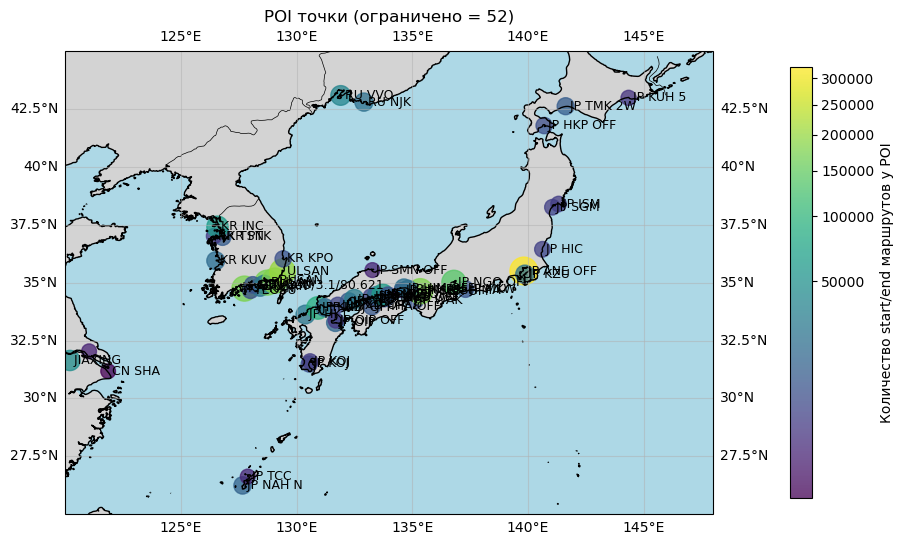

In [97]:
extent = (120.0, 148.0, 25.0, 45.0)

top_label_len = 22          # обрезка подписи
min_count_to_label = 200    # подписи только для достаточно крупных POI
max_labels = 60             # верхний лимит подписей (по убыванию count_total)
gamma = 0.35                # нелинейность для цвета и размеров

lats = np.array([p["center_lat"] for p in pois], dtype=np.float64)
lons = np.array([p["center_lon"] for p in pois], dtype=np.float64)
counts = np.array([p["count_total"] for p in pois], dtype=np.float64)

labels = []
for p in pois:
    td = p.get("top_destinations") or []
    name = td[0]["name"] if td else ""
    name = str(name).strip()
    if len(name) > top_label_len:
        name = name[:top_label_len - 1] + "…"
    labels.append(name)

# фильтр по extent (чтобы не рисовать и не подписывать вне области)
min_lon, max_lon, min_lat, max_lat = map(float, extent)
in_view = (lons >= min_lon) & (lons <= max_lon) & (lats >= min_lat) & (lats <= max_lat)

lats_v = lats[in_view]
lons_v = lons[in_view]
counts_v = counts[in_view]
labels_v = [lab for lab, ok in zip(labels, in_view) if ok]

# размеры точек: нелинейно от count (нормируем на max внутри видимой области)
cmax = float(counts_v.max()) if counts_v.size else 1.0
cmax = max(cmax, 1.0)
sizes_v = 20.0 + 380.0 * (counts_v / cmax) ** gamma

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.5)

# цвет по count_total (только видимая область)
vmin = float(counts_v.min()) if counts_v.size else 1.0
vmin = max(1.0, vmin)
norm = PowerNorm(gamma=gamma, vmin=vmin, vmax=cmax)

sc = ax.scatter(
    lons_v, lats_v,
    s=sizes_v,
    c=counts_v,
    norm=norm,
    alpha=0.75,
    transform=ccrs.PlateCarree(),
    clip_on=True,
)

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", pad=0.09, shrink=0.8)
cbar.set_label("Количество start/end маршрутов у POI")

# подписи: только для видимых точек
order = np.argsort(-counts_v)
printed = 0
for i in order:
    if printed >= max_labels:
        break
    if counts_v[i] < min_count_to_label:
        break
    if not labels_v[i]:
        continue

    ax.text(
        lons_v[i], lats_v[i],
        " " + labels_v[i],
        fontsize=9,
        transform=ccrs.PlateCarree(),
        ha="left", va="center",
        clip_on=True,
    )
    printed += 1

ax.set_title(f"POI точки (ограничено = {printed})", fontsize=12)
plt.show()


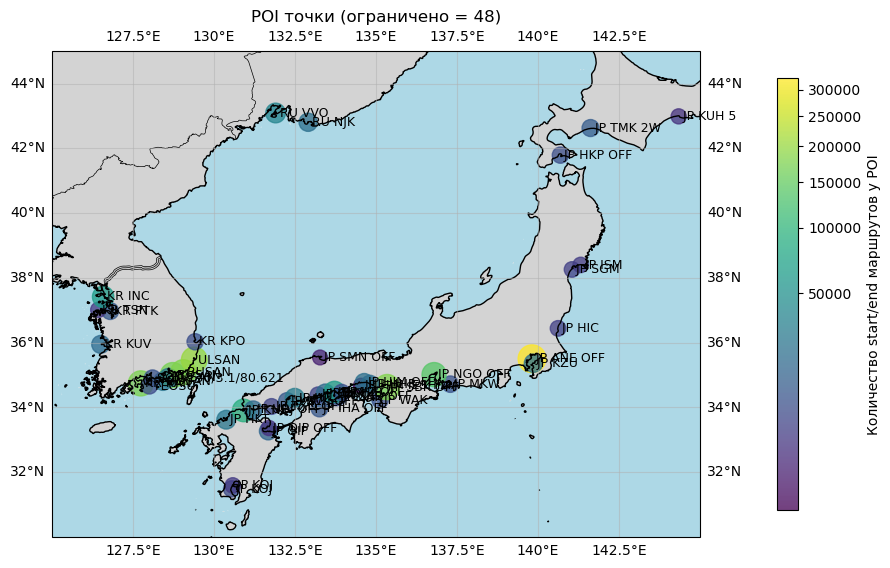

In [98]:
extent = (125.0, 145.0, 30.0, 45.0)

top_label_len = 22          # обрезка подписи
min_count_to_label = 200    # подписи только для достаточно крупных POI
max_labels = 60             # верхний лимит подписей (по убыванию count_total)
gamma = 0.35                # нелинейность для цвета и размеров

lats = np.array([p["center_lat"] for p in pois], dtype=np.float64)
lons = np.array([p["center_lon"] for p in pois], dtype=np.float64)
counts = np.array([p["count_total"] for p in pois], dtype=np.float64)

labels = []
for p in pois:
    td = p.get("top_destinations") or []
    name = td[0]["name"] if td else ""
    name = str(name).strip()
    if len(name) > top_label_len:
        name = name[:top_label_len - 1] + "…"
    labels.append(name)

# фильтр по extent (чтобы не рисовать и не подписывать вне области)
min_lon, max_lon, min_lat, max_lat = map(float, extent)
in_view = (lons >= min_lon) & (lons <= max_lon) & (lats >= min_lat) & (lats <= max_lat)

lats_v = lats[in_view]
lons_v = lons[in_view]
counts_v = counts[in_view]
labels_v = [lab for lab, ok in zip(labels, in_view) if ok]

# размеры точек: нелинейно от count (нормируем на max внутри видимой области)
cmax = float(counts_v.max()) if counts_v.size else 1.0
cmax = max(cmax, 1.0)
sizes_v = 20.0 + 380.0 * (counts_v / cmax) ** gamma

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.5)

# цвет по count_total (только видимая область)
vmin = float(counts_v.min()) if counts_v.size else 1.0
vmin = max(1.0, vmin)
norm = PowerNorm(gamma=gamma, vmin=vmin, vmax=cmax)

sc = ax.scatter(
    lons_v, lats_v,
    s=sizes_v,
    c=counts_v,
    norm=norm,
    alpha=0.75,
    transform=ccrs.PlateCarree(),
    clip_on=True,
)

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", pad=0.09, shrink=0.8)
cbar.set_label("Количество start/end маршрутов у POI")

# подписи: только для видимых точек
order = np.argsort(-counts_v)
printed = 0
for i in order:
    if printed >= max_labels:
        break
    if counts_v[i] < min_count_to_label:
        break
    if not labels_v[i]:
        continue

    ax.text(
        lons_v[i], lats_v[i],
        " " + labels_v[i],
        fontsize=9,
        transform=ccrs.PlateCarree(),
        ha="left", va="center",
        clip_on=True,
    )
    printed += 1

ax.set_title(f"POI точки (ограничено = {printed})", fontsize=12)
plt.show()


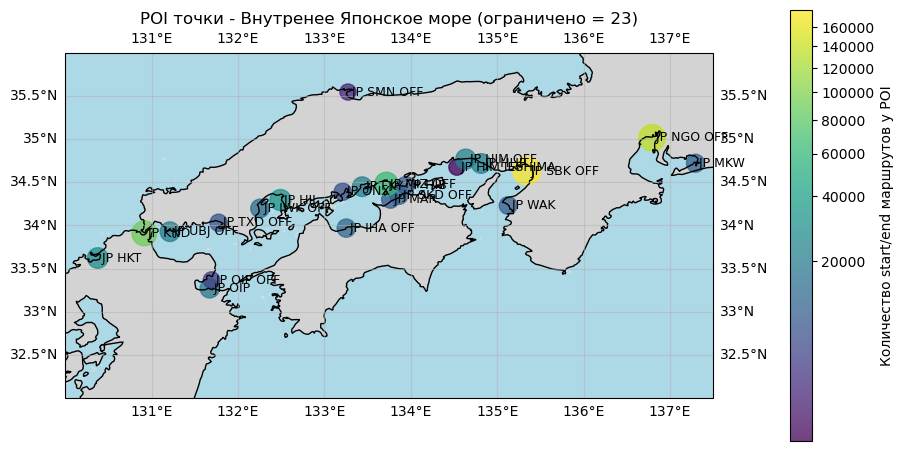

In [99]:
extent = (130.0, 137.5, 32.0, 36.0)

top_label_len = 22          # обрезка подписи
min_count_to_label = 200    # подписи только для достаточно крупных POI
max_labels = 60             # верхний лимит подписей (по убыванию count_total)
gamma = 0.35                # нелинейность для цвета и размеров

lats = np.array([p["center_lat"] for p in pois], dtype=np.float64)
lons = np.array([p["center_lon"] for p in pois], dtype=np.float64)
counts = np.array([p["count_total"] for p in pois], dtype=np.float64)

labels = []
for p in pois:
    td = p.get("top_destinations") or []
    name = td[0]["name"] if td else ""
    name = str(name).strip()
    if len(name) > top_label_len:
        name = name[:top_label_len - 1] + "…"
    labels.append(name)

# фильтр по extent (чтобы не рисовать и не подписывать вне области)
min_lon, max_lon, min_lat, max_lat = map(float, extent)
in_view = (lons >= min_lon) & (lons <= max_lon) & (lats >= min_lat) & (lats <= max_lat)

lats_v = lats[in_view]
lons_v = lons[in_view]
counts_v = counts[in_view]
labels_v = [lab for lab, ok in zip(labels, in_view) if ok]

# размеры точек: нелинейно от count (нормируем на max внутри видимой области)
cmax = float(counts_v.max()) if counts_v.size else 1.0
cmax = max(cmax, 1.0)
sizes_v = 20.0 + 380.0 * (counts_v / cmax) ** gamma

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.5)

# цвет по count_total (только видимая область)
vmin = float(counts_v.min()) if counts_v.size else 1.0
vmin = max(1.0, vmin)
norm = PowerNorm(gamma=gamma, vmin=vmin, vmax=cmax)

sc = ax.scatter(
    lons_v, lats_v,
    s=sizes_v,
    c=counts_v,
    norm=norm,
    alpha=0.75,
    transform=ccrs.PlateCarree(),
    clip_on=True,
)

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", pad=0.09, shrink=0.8)
cbar.set_label("Количество start/end маршрутов у POI")

# подписи: только для видимых точек
order = np.argsort(-counts_v)
printed = 0
for i in order:
    if printed >= max_labels:
        break
    if counts_v[i] < min_count_to_label:
        break
    if not labels_v[i]:
        continue

    ax.text(
        lons_v[i], lats_v[i],
        " " + labels_v[i],
        fontsize=9,
        transform=ccrs.PlateCarree(),
        ha="left", va="center",
        clip_on=True,
    )
    printed += 1

ax.set_title(f"POI точки - Внутренее Японское море (ограничено = {printed})", fontsize=12)
plt.show()
